In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Configure plotting style
plt.rcParams['figure.figsize'] = [13, 5]
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context('notebook', font_scale=1.5)

# Source Data Analysis
Data comes from the following source. It's made up of historical S&P500 returns, 10 Year U.S. Treasury Bond returns, and inflation data from 1928 - 2020.

http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html

In [3]:
# Import historical S&P500, US Treasury Bond, and Inflation data
data = pd.read_csv('historical_data.csv', parse_dates=['year'], index_col='year')

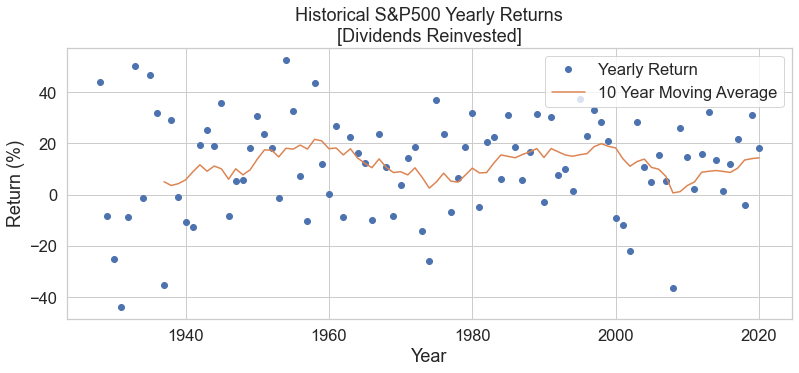

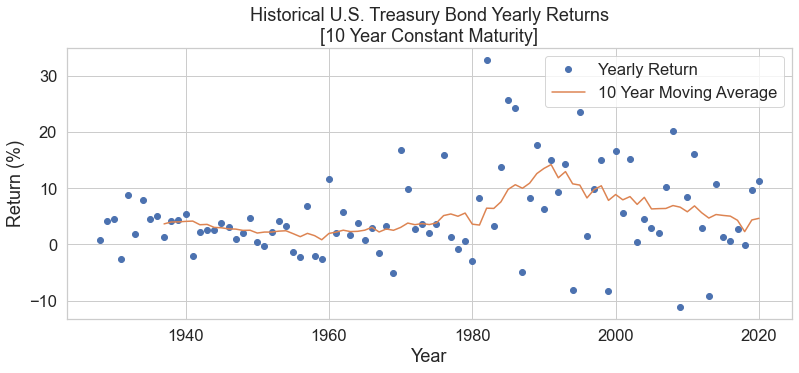

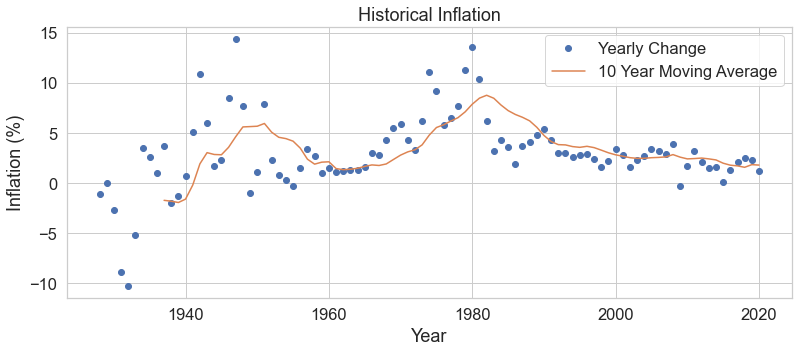

In [4]:
# Plot S&P returns
plt.plot(data.sp500 * 100, 'o')
plt.plot(data.sp500.rolling(10).mean() * 100)
plt.title('Historical S&P500 Yearly Returns\n[Dividends Reinvested]')
plt.xlabel('Year')
plt.ylabel('Return (%)')
plt.legend(['Yearly Return', '10 Year Moving Average'])
plt.show()

# Plot bond returns
plt.plot(data.bonds * 100, 'o')
plt.plot(data.bonds.rolling(10).mean() * 100)
plt.title('Historical U.S. Treasury Bond Yearly Returns\n[10 Year Constant Maturity]')
plt.xlabel('Year')
plt.ylabel('Return (%)')
plt.legend(['Yearly Return', '10 Year Moving Average'])
plt.show()

# Plot inflation
plt.plot(data.inflation * 100, 'o')
plt.plot(data.inflation.rolling(10).mean() * 100)
plt.title('Historical Inflation')
plt.xlabel('Year')
plt.ylabel('Inflation (%)')
plt.legend(['Yearly Change', '10 Year Moving Average'])
plt.show()

## Distribution of Historical Returns
Histograms (with kernal density estimates) are plotted below for the S&P500 and Treasury Bond returns as well as inflation.

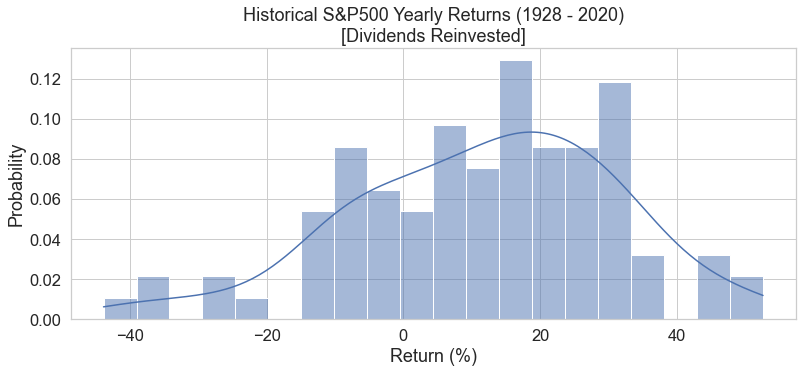

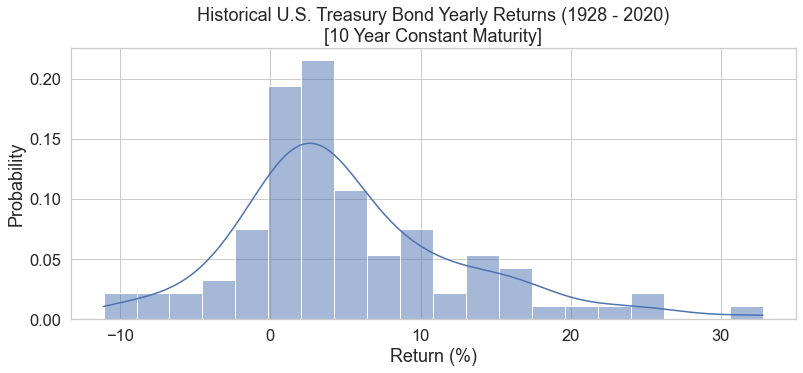

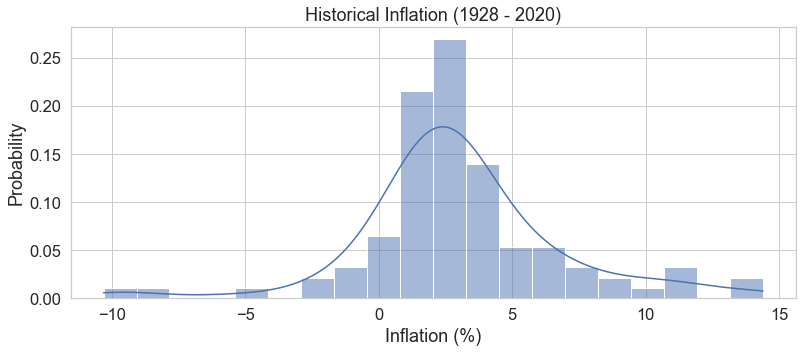

In [5]:
# Create histogram of S&P returns
sns.histplot(data.sp500 * 100, stat='probability', kde=True, bins=20)
plt.title('Historical S&P500 Yearly Returns (1928 - 2020)\n[Dividends Reinvested]')
plt.xlabel('Return (%)')
plt.show()

# Create histogram of Bond returns
sns.histplot(data.bonds * 100, stat='probability', kde=True, bins=20)
plt.title('Historical U.S. Treasury Bond Yearly Returns (1928 - 2020)\n[10 Year Constant Maturity]')
plt.xlabel('Return (%)')
plt.show()

# Create histogram of Inflation
sns.histplot(data.inflation * 100, stat='probability', kde=True, bins=20)
plt.title('Historical Inflation (1928 - 2020)')
plt.xlabel('Inflation (%)')
plt.show()

## Historical Growth
This section analyzes the historical growth of both the S&P500 and U.S. Treasury Bonds. Results are adjusted for inflation.

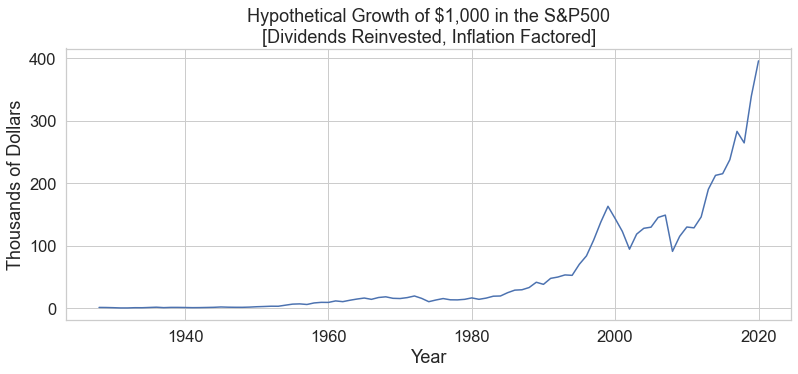

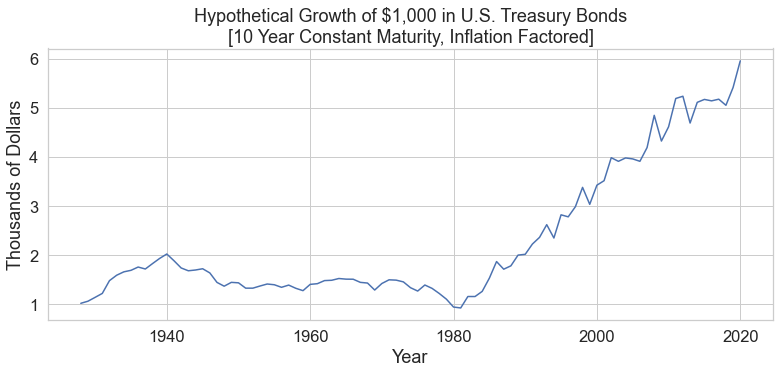

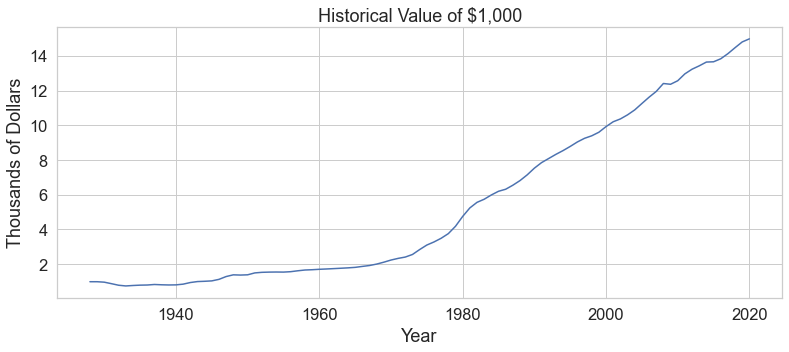

In [6]:
# Date range
dateRange = [pd.Timestamp('1920'), pd.Timestamp('2020')]
ind       = (data.index >= dateRange[0]) & (data.index <= dateRange[1])

# Plot theoretical growth of $1K in S&P accounting for inflation
plt.plot(((data.sp500[ind] + 1) / (data.inflation[ind] + 1)).cumprod() * 1000 / 1000)
plt.title('Hypothetical Growth of $1,000 in the S&P500\n[Dividends Reinvested, Inflation Factored]')
plt.xlabel('Year')
plt.ylabel('Thousands of Dollars')
plt.show()

# Plot theoretical growth of $1K in Bonds accounting for inflation
plt.plot(((data.bonds[ind] + 1) / (data.inflation[ind] + 1)).cumprod() * 1000 / 1000)
plt.title('Hypothetical Growth of $1,000 in U.S. Treasury Bonds\n[10 Year Constant Maturity, Inflation Factored]')
plt.xlabel('Year')
plt.ylabel('Thousands of Dollars')
plt.show()

# Plot the value of $1K over time
plt.plot((data.inflation[ind] + 1).cumprod() * 1000 / 1000)
plt.title('Historical Value of $1,000')
plt.xlabel('Year')
plt.ylabel('Thousands of Dollars')
plt.show()

# Retirement Analysis (Historical)
In this section we evaluate the performance of various stock/bond allocations for a 35 year retirement. The account starts at \\$1M and \\$40K withdrawals are taken each year. Beginning in 1928, successive 35 year windows are analyzed. Results are adjusted for inflation.

In [7]:
# Simulate investment strategy
def invest(start, years, stocks, bonds, initialBalance, withdrawal):
    # Create the date range
    simRange = pd.date_range(start, periods=years + 1, freq='YS')

    # Starting balance
    balance    = np.zeros(len(simRange))
    balance[0] = initialBalance
    
    # Extract returns
    for i in range(len(simRange) - 1):
        # Isolate data to current year
        dataYear = data[data.index == simRange[i]]

        # Calculate the new balance
        balance[i + 1]  = (dataYear.sp500[0] + 1) * stocks * balance[i]
        balance[i + 1] += (dataYear.bonds[0] + 1) * bonds  * balance[i]
        balance[i + 1] /= (dataYear.inflation[0] + 1)
        balance[i + 1] -= withdrawal
        balance[i + 1]  = np.max([0, balance[i + 1]])

    # Create and return results
    return pd.DataFrame(balance, simRange, columns=['balance'])

# Run experiment
def experiment(stocks, bonds, years, balance, withdrawal, plot=True):
    # Simulate returns
    returns = []
    for date in data.index[0:-years]:
        returns.append(invest(date, years, stocks / 100, bonds / 100, balance, withdrawal))
        if plot:
            plt.plot(returns[-1].balance / 1000)

    # Label graph
    if plot:
        plt.title(f'{years} Year Growth of \${balance / 1e6:.0f}M with a \${withdrawal / 1e3:.0f}K Yearly Withdrawal\n' \
                  f'Stocks: {stocks:.0f}%, Bonds: {bonds:.0f}%\n' \
                   '[Rebalanced Annually, Inflation Factored]')
        plt.xlabel('Year')
        plt.ylabel('Thousands of Dollars')
        plt.show()
    
    # Return final balances
    return pd.DataFrame([entry.balance[-1] / 1000 for entry in returns], data.index[0:-years], columns=['balance'])

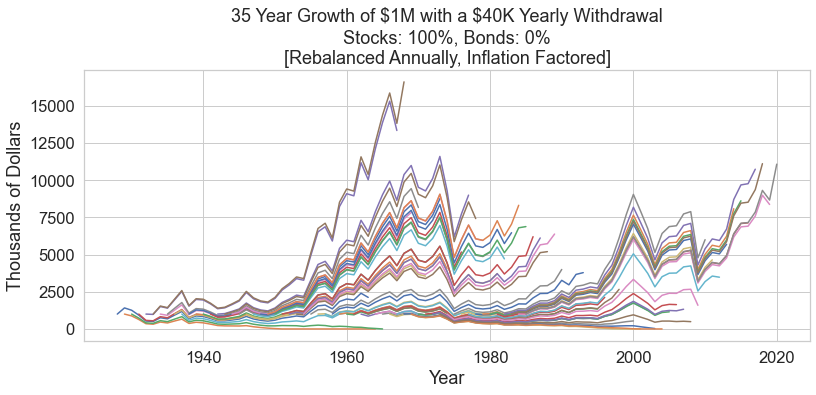

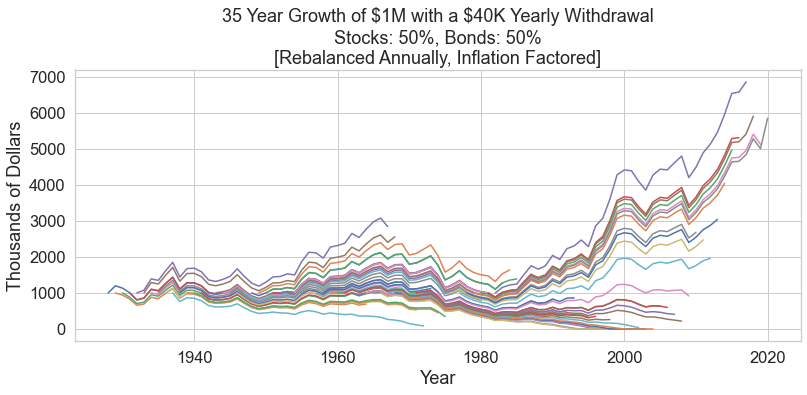

In [8]:
# Evaluate splits over 35 years with a $1M starting balance and $40K yearly withdrawals
final_100_0 = experiment(100, 0, 35, 1e6, 40e3)
final_90_10 = experiment(90, 10, 35, 1e6, 40e3, False)
final_80_20 = experiment(80, 20, 35, 1e6, 40e3, False)
final_70_30 = experiment(70, 30, 35, 1e6, 40e3, False)
final_60_40 = experiment(60, 40, 35, 1e6, 40e3, False)
final_50_50 = experiment(50, 50, 35, 1e6, 40e3)

## Summary
The following plot shows your final account balance after 35 years of investing starting in the indicated year. The table below shows the number of 35 year periods where the account was depleted as well as the mean account value at the end.

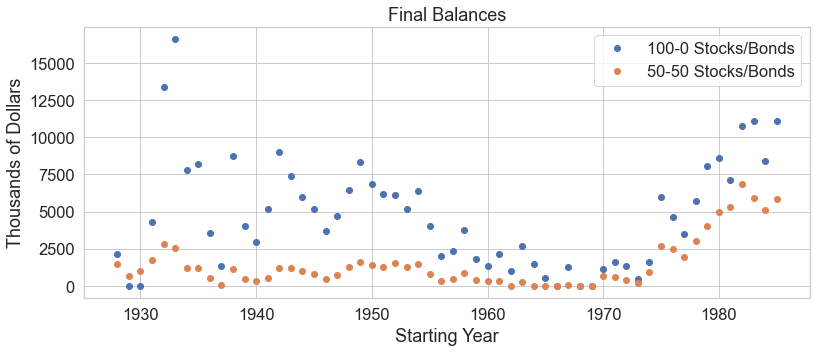

                Zero Ending  Mean Ending
Stocks  Bonds   Balance      Balance
------  ------  -----------  -----------
100%    0%       4           $4745.7K
90%     10%      3           $3935.2K
80%     20%      3           $3204.0K
70%     30%      4           $2553.6K
60%     40%      4           $1979.6K
50%     50%      6           $1480.8K


In [9]:
# Plot the final balances
plt.plot(final_100_0, 'o')
plt.plot(final_50_50, 'o')
plt.title('Final Balances')
plt.xlabel('Starting Year')
plt.ylabel('Thousands of Dollars')
plt.legend(['100-0 Stocks/Bonds', '50-50 Stocks/Bonds'])
plt.show()

# Display stats
print(f'                Zero Ending  Mean Ending')
print(f'Stocks  Bonds   Balance      Balance')
print(f'------  ------  -----------  -----------')
print(f'100%    0%      {(final_100_0.balance == 0).sum():2.0f}           ${final_100_0.mean()[0]:.1f}K')
print(f'90%     10%     {(final_90_10.balance == 0).sum():2.0f}           ${final_90_10.mean()[0]:.1f}K')
print(f'80%     20%     {(final_80_20.balance == 0).sum():2.0f}           ${final_80_20.mean()[0]:.1f}K')
print(f'70%     30%     {(final_70_30.balance == 0).sum():2.0f}           ${final_70_30.mean()[0]:.1f}K')
print(f'60%     40%     {(final_60_40.balance == 0).sum():2.0f}           ${final_60_40.mean()[0]:.1f}K')
print(f'50%     50%     {(final_50_50.balance == 0).sum():2.0f}           ${final_50_50.mean()[0]:.1f}K')

# Retirement Analysis (Simulated)
In order to get a better understanding of the range of possible outcomes, a Monte Carlo analysis is performed where the historical S&P500 and U.S. Treasury Bond returns are randomly sampled for 35 years. Inflation is also randomly sampled, but only from 1970 forward since that year marks the inflection point in historical inflation.

In [10]:
# Extract all returns for the S&P and Bonds
simData = {
    'sp500': data.sp500.to_numpy(),
    'bonds': data.bonds.to_numpy()
}

# Only utilize inflation data from 1970 onwards
simData['inflation'] = data.inflation[data.index >= pd.Timestamp('1970')].to_numpy()

# Simulate random sampled returns
def invest(simData, stocks, bonds, years, initialBalance, withdrawal, N):
    # Starting balance
    balance      = np.zeros([years + 1, N])
    balance[0,:] = initialBalance
    
    # Take draws
    all_inflation = np.random.choice(data['inflation'], [years,N])
    all_sp500     = np.random.choice(data['sp500'], [years,N])
    all_bonds     = np.random.choice(data['bonds'], [years,N])
    
    # Extract returns
    for i in range(years):
        # Calculate the new balance
        balance[i + 1,:]  = (all_sp500[i,:] + 1) * stocks * balance[i,:]
        balance[i + 1,:] += (all_bonds[i,:] + 1) * bonds  * balance[i,:]
        balance[i + 1,:] /= (all_inflation[i,:] + 1)
        balance[i + 1,:] -= withdrawal
        balance[i + 1,:]  = np.max(np.stack((np.zeros(N), balance[i + 1,:])), 0)

    # Create and return results
    return balance[-1,:] / 1000

def experiment(target, showLegend=False):
    # Evaluate multiple strategies
    stockLevel = np.linspace(0, 100, 11)
    spendLevel = np.linspace(0, 5, 6)

    # Collect data
    results = np.zeros([len(spendLevel), len(stockLevel)])
    for i in range(len(stockLevel)):
        for j in range(len(spendLevel)):
            results[j,i] = np.percentile(invest(simData, 
                  stockLevel[i] / 100, 1 - stockLevel[i] / 100, 35, 1e6, 1e6 * spendLevel[j] / 100, 1000000), 100 - target)

    # Plot results
    plt.plot(stockLevel, results.transpose())
    plt.xlabel('Stock Allocation (%)')
    plt.ylabel('Thousands of Dollars')
    plt.title(f'35 Year Return on $1M ({target:.1f}% Worst)')
    if showLegend:
        plt.legend([f'${entry / 1000:.0f}K Yearly Withdrawal' for entry in spendLevel / 100 * 1e6], 
              loc="lower center", bbox_to_anchor=(0.5, 1.2), ncol=3)
    plt.show()

## Results
The final account balance for various stock allocation percentages and yearly withdrawals are shown below. Each graph represents a different level of conservatism. The first graph looks at the 99.9% worst returns, in other words 99.9% of the time the final account balance is higher than what is indicated. The following graphs reduce the conservatism analyzing the 99%, 90%, and 50% worst (mean value) returns.

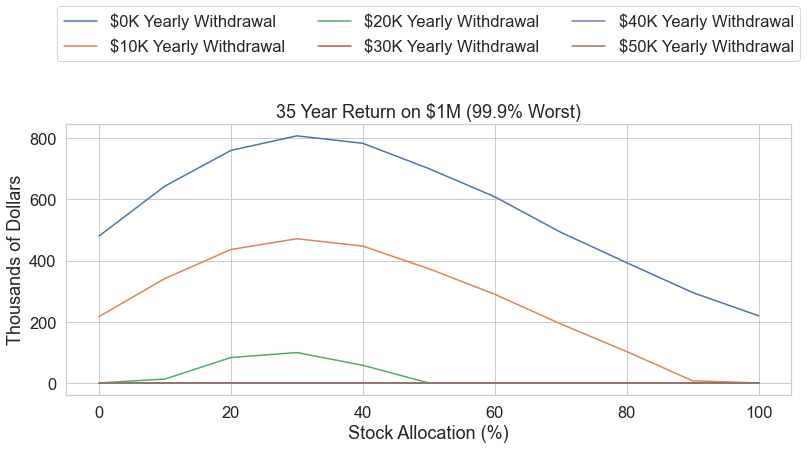

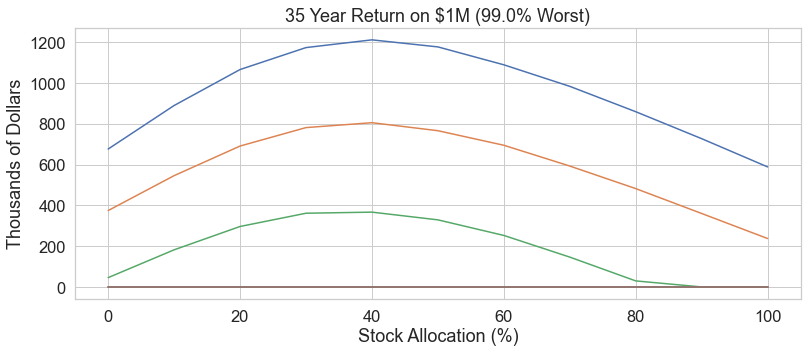

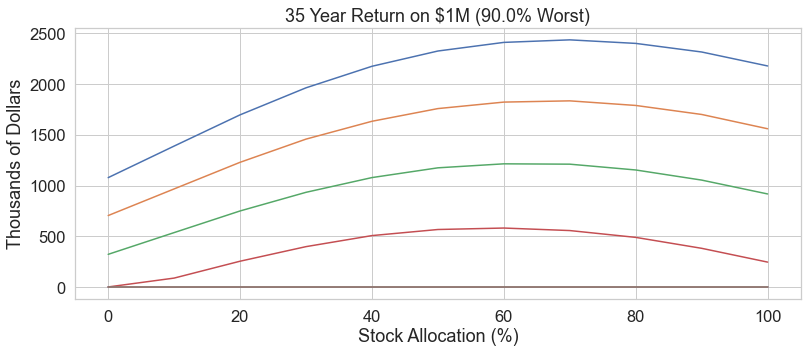

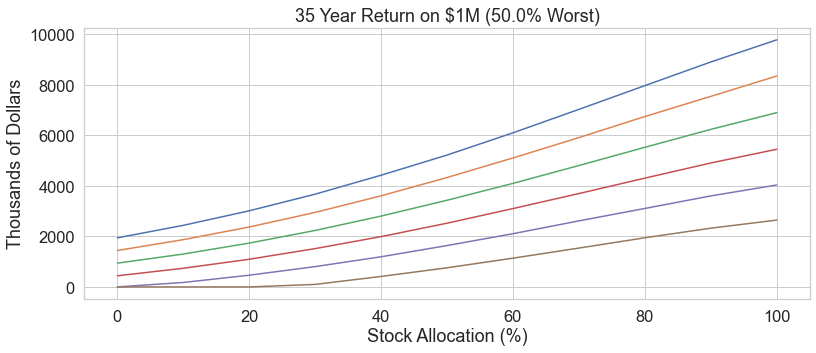

In [11]:
# Evaluate performance for various percentiles
experiment(99.9, True)
experiment(99)
experiment(90)
experiment(50)

## Conclusions
As expected, the preferred stock/bond allocation strategy is highly dependent on your risk tolerance and yearly withdrawal. An 80/20 stocks-bonds split for example will be safe 99% of the time with a \\$20K yearly withdrawal on a \\$1M initial principal. You could opt for a 40/60 split and optimize your expected 99% worst-case return, however you would expect your mean return (50% worst-case) to decrease from ~\\$5.5M to ~\\$3M.